<a href="https://colab.research.google.com/github/Morilla123/Curso/blob/main/multi_mnist_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Mnist Base-Line

## Inport librarys

In [ ]:
import numpy as np                   # math library
import matplotlib.pyplot as plt      
import random                        # for generating random numbers
from google.colab.patches import cv2_imshow
import tensorflow as tf
import seaborn as sns
import cv2


from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils  
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

### Fix compatibiliti problem whit cv2

In [ ]:
%%capture
!pip install opencv-python-headless=='4.1.2.30'
# !pip list | grep open


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Mount Google Drive acceses to Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load dato Mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [ ]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


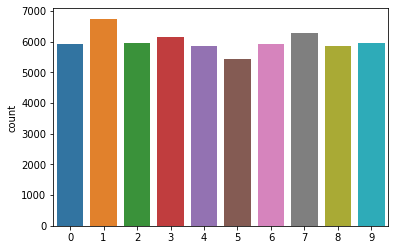

In [ ]:
sns.countplot(y_train)

5


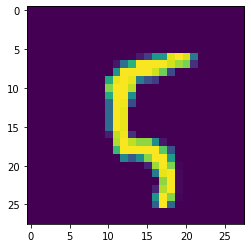

In [ ]:
plt.imshow(X_train[100][:,:,0])
print(y_train[100])

In [ ]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

## Model Mnist Simple

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax')) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

### Model compile

In [ ]:
epochs = 5
batch_size = 64

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)

### Model fit

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs= epochs, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
467/468 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9471

TypeError: ignored

### Evaluate metrics

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

In [ ]:
Y_test.shape

In [ ]:
# Convert testing observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

## Save model

In [ ]:
model.save('MNIST.h5')

## Prepros data for inference

In [ ]:
plt.imshow(X_train[143][:,:,0])
print(y_train[143])
test = X_train[143][:,:,0]

In [ ]:
img = cv2.imread('/content/99.jpg')
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(img.shape)

In [ ]:
hight,width,_ = img.shape 
print(hight,width)

In [ ]:
img = img[0:hight,int(width/2):width]
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(img.shape)

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # es posible que esta linea no la necesitemos

In [ ]:
# test = img

In [ ]:
img = cv2.Canny(img, 250, 250)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(img.shape)

In [ ]:
# Inecesario
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
# dilate = cv2.dilate(canny, kernel, iterations=1)
# cv2_imshow(dilate)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(dilate.shape)

In [ ]:
# cont,jerarq=cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# len(cont)

In [ ]:
# c = max(cont, key=cv2.contourArea)
# rect = cv2.minAreaRect(c)
# box = cv2.boxPoints(rect)
# img = cv2.drawContours(img, [np.int0(box)], -1, (255,0 , 2), 2)

In [ ]:
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(img.shape)

In [ ]:
# img = cv2.resize(img,(28,28))
dim = (28,28)
img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(img.shape)

In [ ]:
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(img.shape)

In [ ]:
img = np.expand_dims(img, axis=-1)
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(img.shape)

In [ ]:
# img.shape

In [ ]:
img = np.expand_dims(img, axis=0)
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(img.shape)

In [ ]:
test = np.expand_dims(test, axis=0)
test = np.expand_dims(test, axis=-1)
test.shape


In [ ]:
predictions = model.predict(test)
predictions[0]

In [ ]:
score = np.argmax(predictions[0])
score

# Multi Mnist


## Import libraris

In [ ]:
%%capture 
!pip install opencv-python-headless=='4.1.2.30'
!pip install rarfile
!apt-get install rar
# !pip list | grep open

In [ ]:
import numpy as np                   # math library
import matplotlib.pyplot as plt      
import random                        # for generating random numbers
from google.colab.patches import cv2_imshow
import tensorflow as tf
import seaborn as sns
import cv2
import rarfile
import os
import datetime

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils  
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Mount Google Drive acceses to Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !ls -s /content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/'train'/ 
# !unzip '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu.zip' -d '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu'
# !ls -s /content/drive/Shareddrives/ML-IALAB/peru/'Simple_Double_Mnist'/test_zip/test/00# con este codigo contas los arcivos tiene que haber 0.3k 
# for i in os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/train'):
#   print(str(i), len(os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/train/'+ str(i))))
# !unzip '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/testfacu.zip' -d '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/testfacu'
# for i in os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/testfacu/test'):
#   print(str(i), len(os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/testfacu/test/'+ str(i))))

## DATA

In [ ]:
# data_dir = '/content/drive/Shareddrives/ML-IALAB/peru/mnist_double/data_simple_double_mnist_0-44'
data_dir_train = '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/train'
data_dir_test = '/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/testfacu/test'

In [ ]:
batch_size_data = 32
image_size = (28, 28)
split_val = 0.2
seed = 123

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                        #        width_shift_range=0.08,
                        #        shear_range=0.3,
                        #  height_shift_range=0.08,
                        #   zoom_range=0.08,
                        #   rotation_range=8
                           )

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_gen.flow_from_directory(data_dir_test,
                                              batch_size= batch_size_data,
                                              class_mode="categorical",
                                              target_size= image_size
                                              ) 

Found 16500 images belonging to 55 classes.


In [ ]:
train_generator = train_gen.flow_from_directory(data_dir_train,
                                                batch_size=batch_size_data,
                                                class_mode="categorical",
                                                target_size= image_size
                                                )

Found 38500 images belonging to 55 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 28, 28, 3)
(32, 55)


In [ ]:
num_classes = 55

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1

model.add(Conv2D(32, (3, 3), input_shape=(28,28,3))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2

model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3

model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# # Convolution Layer 4

model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)

model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector
model.add(Dropout(0.5)) 

# Fully Connected Layer 5

model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6 

model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(num_classes),)                       # final 10 FCN nodes
                      
model.add(Activation('softmax')) 

### Model compile

In [ ]:
epochs = 25
batch_size = 64
len_train = 38500 
len_test = 16500 

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # para tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # para tensorboard 

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

TypeError: ignored

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') is not None and logs.get('acc')>0.99):
      print("\n Se llego al 99% de accuracy!, jaj basta")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# model.summary()

### Model fit

In [ ]:
history = model.fit(train_generator,
                              steps_per_epoch=int(len_train/128),
                              epochs= epochs, 
                              verbose=1, 
                              validation_data=test_generator,
                              validation_steps=len_test//64,
                              callbacks=[callbacks]
                               )
model.save("pone direccion de guardado pelado")

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
etiquetas=os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/train')


for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(28, 28))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=55)
  print(fn)
  print(classes)


In [ ]:
etiquetas=os.listdir('/content/drive/Shareddrives/ML-IALAB/peru/Simple_Double_Mnist/trainfacu/train')
print(etiquetas)

### Evaluate metrics

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

In [ ]:
Y_test.shape

In [ ]:
# Convert testing observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

## Save model

In [ ]:
model.save('MNIST.h5')

In [2]:
%%capture
!pip install opencv-python-headless=='4.1.2.30'
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

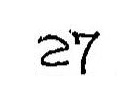

(109, 136, 3)

In [3]:
img = cv2.imread("/content/27.jpg")
cv2_imshow(img)
img.shape

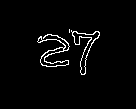

(109, 136)

In [4]:
img = cv2.Canny(img, 250, 250)
cv2_imshow(img)
img.shape

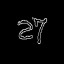

(64, 64)

In [5]:
dim = (64,64)
img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
cv2_imshow(img)
img.shape

In [ ]:
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=1)

img = np.expand_dims(img, axis=-1)
# cv2_imshow(img)
img.shape

In [8]:
img.shape

(1, 1, 64, 64, 1)